##Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Model
np.random.seed(10)

##Data Exploration

In [2]:
df=pd.read_csv('/content/drive/MyDrive/Dataset/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [4]:
fraud_percent = 100*df['Class'].value_counts()[1]/df.shape[0]
print(f'fraud transaction percentage : {round(fraud_percent,3)}%')

fraud transaction percentage : 0.173%


In [5]:
df.drop(columns=['Time'],inplace=True)
X=df.drop(columns=['Class'])
y=df['Class']

In [6]:
X.shape, y.shape

((284807, 29), (284807,))

In [7]:
#Confusion Matrix Visualization
from sklearn.metrics import confusion_matrix
def heatmap_confusion_matrix(y_true, y_pred, statement):
    print(statement)
    cm=confusion_matrix(y_true,y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(6,4))
    sns.set(font_scale=1.2)
    sns.heatmap(cm,annot=labels,fmt='',cmap='Blues')
    plt.xlabel("Predicted Value")
    plt.ylabel("Actual Value")
    plt.show()

#Classification Metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
def classification_metrics(y_true, y_predict):
    print("Accuracy Score  : ",round(accuracy_score(y_true,y_predict),3))
    print("Precision Score : ",round(precision_score(y_true,y_predict),3))
    print("Recall Score    : ",round(recall_score(y_true,y_predict),3))
    print("F1 Score        : ",round(f1_score(y_true,y_predict),3))

##Neural Network on actual data

In [8]:
def train_and_evaluate_neural_network(X, y, name, X_org, y_org, eval_original):
    
    #Splitting data into train and test
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
    print(x_train.shape, x_test.shape)

    #Normalization of data
    scale = StandardScaler()
    x_train = scale.fit_transform(x_train)
    x_test = scale.transform(x_test)
    
    #Neural Network model and train
    print(name)
    i = Input(X.shape[1])
    x = Dense(50, activation='relu')(i)
    x = Dense(50, activation='relu')(x)
    x = Dense(5, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    history = model.fit(x_train, y_train, epochs=30, batch_size=256, verbose=0)

    #Prediction on test data and original data
    y_pred = (model.predict(x_test)>=0.5)
    heatmap_confusion_matrix(y_test, y_pred, 'Result on test data')
    classification_metrics(y_test, y_pred)
    if eval_original:
        y_pred = (model.predict(scale.transform(X_org))>=0.5)
        heatmap_confusion_matrix(y_org, y_pred, 'Result on original data')

(199364, 29) (85443, 29)
Neural Network
Result on test data


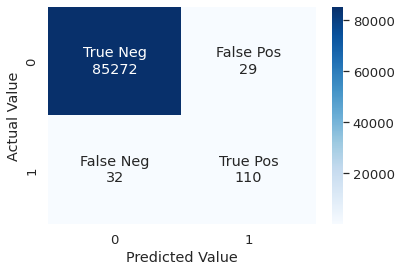

Accuracy Score  :  0.999
Precision Score :  0.791
Recall Score    :  0.775
F1 Score        :  0.783


In [9]:
train_and_evaluate_neural_network(X, y, 'Neural Network', X, y, False)

##UnderSampling

In [10]:
from sklearn.utils import shuffle
fraud = df[df['Class']==1].copy()
non_fraud = df[df['Class']==0].copy()
non_fraud = shuffle(non_fraud, random_state=42)
non_fraud = non_fraud[0:fraud.shape[0]*9].copy()
non_fraud.shape

(4428, 30)

In [11]:
data = pd.concat([non_fraud, fraud])
data = shuffle(data, random_state=42)
X_under = data.drop(columns=['Class'])
y_under = data['Class']
y_under.value_counts()

0    4428
1     492
Name: Class, dtype: int64

(3444, 29) (1476, 29)
Neural Network with UnderSampling
Result on test data


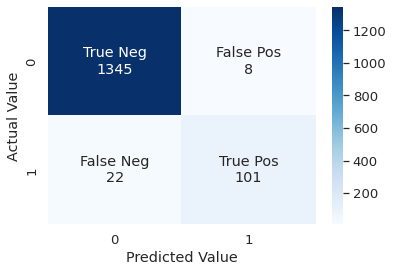

Accuracy Score  :  0.98
Precision Score :  0.927
Recall Score    :  0.821
F1 Score        :  0.871
Result on original data


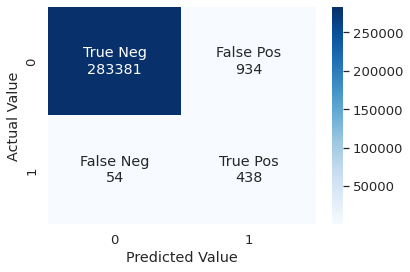

In [12]:
train_and_evaluate_neural_network(X_under, y_under, 'Neural Network with UnderSampling', X, y, True)

##OverSampling using Smote

In [13]:
X = df.drop(columns=['Class'])
y = df['Class']

In [14]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_over, y_over = smote.fit_resample(X, y)

In [15]:
data = pd.concat([X_over, y_over], axis=1)
data = shuffle(data, random_state=42)
X_over = data.drop(columns=['Class'])
y_over = data['Class']
y_over.value_counts()

1    284315
0    284315
Name: Class, dtype: int64

(398041, 29) (170589, 29)
Neural Network with OverSampling using SMOTE
Result on test data


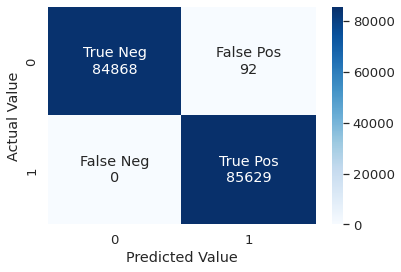

Accuracy Score  :  0.999
Precision Score :  0.999
Recall Score    :  1.0
F1 Score        :  0.999
Result on original data


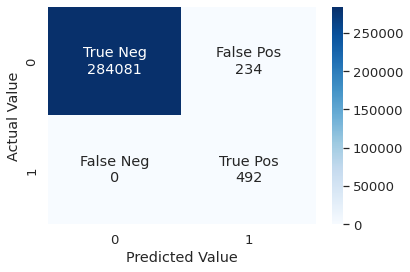

In [16]:
train_and_evaluate_neural_network(X_over, y_over, 'Neural Network with OverSampling using SMOTE', X, y, True)